## Introduction

Historic Downfalls of the perceptron was that it cannot learn nontrivial patterns present in data. For example, in XOR situation in which decision boundry cannot be single straight line, Perceptron fails to learn this decision boundry.

![Figure 4.1](../images/figure_4_1.png)

**Feed-Forward** network is any neural network in which data flows in one direction(ie from input to output). By definition, perceptron is also a _feed-forward_ modelm but usually the term is reserved for more complicated models with multiple units.

Two types of _Feed Forward Neural Networks_:

- **Multilayer Perceptron(MLP)**
    - MLP structurally extends the simpler perceptron by grouping many perceptrons in a single layer and stacking multiple layers together.
- **Convolutional Neural Network(CNN)**
    - CNNs are able to learn localized patterns in the inputs using windowing propertry which is inspired by windowed filters in the processing of digital signals.

## The Multilayer Perceptron

The Perceptron takes the data vector as input and computes a single output value. In an MLP, many perceptrons are grouped so that output of a single layer is a new vector instead of a single output value. Additionally MLP combines multiple layers with nonlinearity in between each layer.

The simplest MLP is composed of 3 stages of representation and two linear layers. The first stage is the _input vector_. Given this input vector, the _First Linear Layer_ computes a _hidden vector_ which is the _second stage of representation_. Using the hidden vector, the _Second Linear Layer_ computes an _output vector_.

![Figure 4.2](../images/figure_4_2.png)

The power of MLPs comes from adding the second Linear Layer and allowing the model to learn an intermediate representation that is _linearly separable_ - a property of representations in which a single straight line can be used to distinguish the data points by whcih side of the line they fall on.

### A Simple Example: XOR

In Figure 4.3 We can see that perceptron has difficulty in learning a decision boundry that can separate the stars and circles however the MLP learns a decision boundry that classifies the stars and the circles more accurately.

![Figure 4.3](../images/figure_4_3.png)

It may appear that MLP has two decision boundries but is just one decision boundry because it has been constructed using the intermediate representation that has morphed the space to allow one hyperplane to appear in bith of these positions. This can be visualised in Figure 4.4 and 4.5

![Figure 4.4](../images/figure_4_4.png)

![Figure 4.5](../images/figure_4_5.png)

### Implementing MLPs in PyTorch

In [154]:
# Multilayer perceptron using PyTorch
%load_ext nb_black

import torch.nn as nn
import torch.nn.functional as F


class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """
        The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor x_in.shape
                should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate = F.relu(self.fc1(x_in))
        output = self.fc2(intermediate)

        if apply_softmax:
            output = F.softmax(output, dim=1)
        return output

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [155]:
batch_size, input_dim, hidden_dim, output_dim = 2, 3, 100, 4

mlp = MultilayerPerceptron(input_dim, hidden_dim, output_dim)
print(mlp)

MultilayerPerceptron(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)


<IPython.core.display.Javascript object>

In [156]:
import torch


def describe(x):
    print(f"Type: {x.type()}")
    print(f"Shape Size: {x.shape}")
    print(f"Values: {x}")


x_input = torch.rand(batch_size, input_dim)
describe(x_input)

y_output = mlp(x_input, apply_softmax=False)
describe(y_output)

y_output = mlp(x_input, apply_softmax=True)
describe(y_output)

Type: torch.FloatTensor
Shape Size: torch.Size([2, 3])
Values: tensor([[0.2769, 0.8282, 0.5582],
        [0.9743, 0.5521, 0.3177]])
Type: torch.FloatTensor
Shape Size: torch.Size([2, 4])
Values: tensor([[-0.2551,  0.1450,  0.0528,  0.1415],
        [-0.1871,  0.0561,  0.1939,  0.3011]], grad_fn=<AddmmBackward>)
Type: torch.FloatTensor
Shape Size: torch.Size([2, 4])
Values: tensor([[0.1873, 0.2794, 0.2548, 0.2785],
        [0.1863, 0.2376, 0.2727, 0.3035]], grad_fn=<SoftmaxBackward>)


<IPython.core.display.Javascript object>

### 2D Points Example

In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [158]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]

<IPython.core.display.Javascript object>

#### Defining the model

In [159]:
class MultilayerPerceptron(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size=2,
        output_size=3,
        num_hidden_layers=1,
        hidden_activation=nn.Sigmoid,
    ):
        """
        Init Wegiths.

        Args:
            input_size (int): size of the input
            hidden_size (int): size of the hidden layers
            output_size (int): size of the output
            num_hidden_layers (int): number of the hidden layers
            hidden_activation (torch.nn.*): the activation class
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()

        interim_input_size = input_size
        interim_output_size = hidden_size

        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size

        self.fc_final = nn.Linear(interim_input_size, output_size)
        self.last_forward_cache = []

    def forward(self, x, apply_softmax=False):
        """
        The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy Loss

        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())

        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
        return output

<IPython.core.display.Javascript object>

#### Get Data Function

In [160]:
def get_toy_data(batch_size):
    assert len(CENTERS) == len(LABELS), "centers should have equal number labels"

    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(CENTERS)

    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx]))
        y_targets[batch_i] = LABELS[center_idx]
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(
        y_targets, dtype=torch.int64
    )

<IPython.core.display.Javascript object>

#### Visualzing Results function

In [167]:
def visualize_results(
    perceptron,
    x_data,
    y_truth,
    n_samples=1000,
    ax=None,
    epoch=None,
    title="",
    levels=[0.3, 0.4, 0.5],
    linestyles=["--", "-", "--"],
):
    _, y_pred = perceptron(x_data, apply_softmax=True).max(dim=1)
    y_pred = y_pred.data.numpy()

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()

    n_classes = len(set(LABELS))

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]

    colors = ["black", "white"]
    markers = ["o", "*"]

    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 10))

    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(
            x_list[:, 0],
            x_list[:, 1],
            edgecolor="black",
            marker=marker,
            facecolor=color_list,
            s=100,
        )

    xlim = (
        min([x_list[:, 0].min() for x_list in all_x]),
        max([x_list[:, 0].max() for x_list in all_x]),
    )
    ylim = (
        min([x_list[:, 1].min() for x_list in all_x]),
        max([x_list[:, 1].max() for x_list in all_x]),
    )

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32), apply_softmax=True)
        Z = Z[:, i].data.numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)
    plt.suptitle(title)
    if epoch is not None:
        plt.text(xlim[0], ylim[1], f"Epoch = {epoch}")

<IPython.core.display.Javascript object>

#### Initial Data Plot

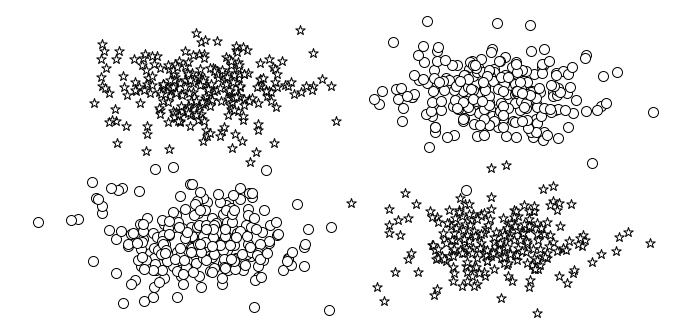

<IPython.core.display.Javascript object>

In [168]:
seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data, x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)

n_classes = len(set(LABELS))

all_x = [[] for _ in range(n_classes)]
all_colors = [[] for _ in range(n_classes)]

colors = ["black", "white"]
markers = ["o", "*"]

for x_i, y_true_i in zip(x_data, y_truth):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(colors[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]

_, ax = plt.subplots(1, 1, figsize=(10, 5))

for x_list, color_list, marker in zip(all_x, all_colors, markers):
    ax.scatter(
        x_list[:, 0],
        x_list[:, 1],
        edgecolor="black",
        marker=marker,
        facecolor="white",
        s=100,
    )

plt.tight_layout()
plt.axis("off")

plt.title("")

plt.savefig("images/data.png")
plt.savefig("images/data.pdf")

#### Training a Perceptron

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


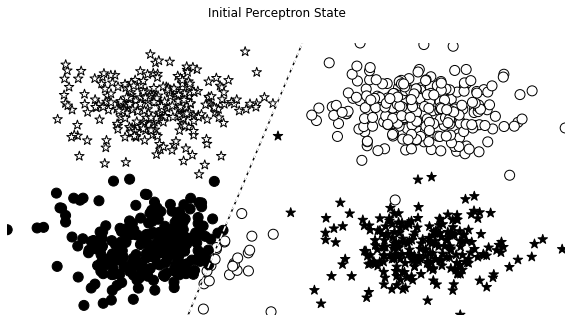

<IPython.core.display.Javascript object>

In [169]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 0
hidden_size = 2

seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlpl = MultilayerPerceptron(
    input_size=input_size,
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    output_size=output_size,
)
print(mlpl)

batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_results(
    mlpl,
    x_data_static,
    y_truth_static,
    ax=ax,
    title="Initial Perceptron State",
    levels=[0.5],
)

plt.axis("off")
plt.savefig("images/perceptron_initial.png")

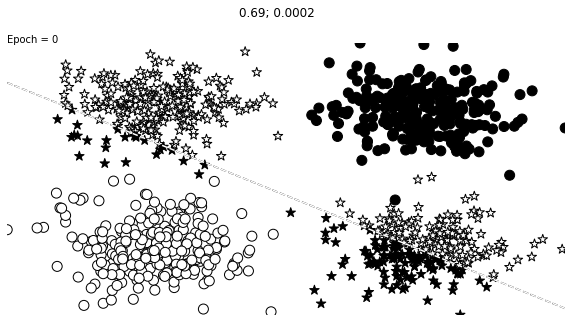

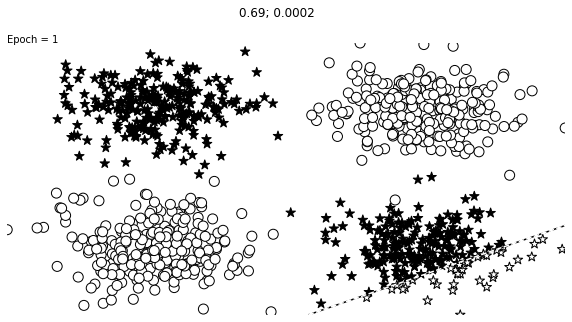

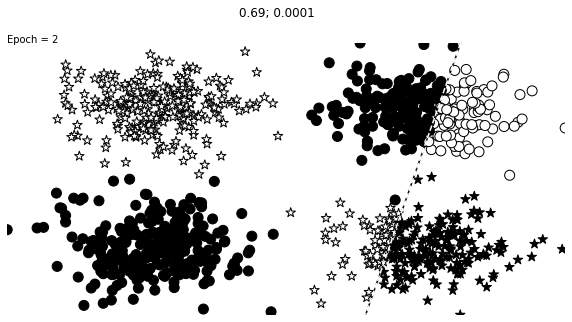

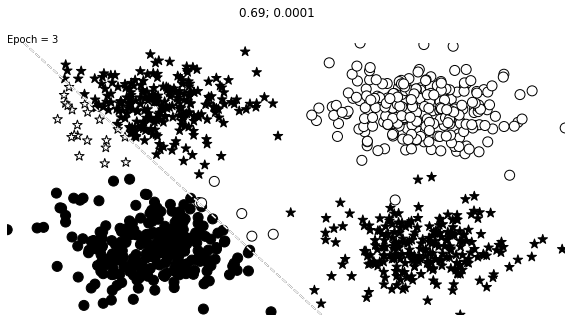

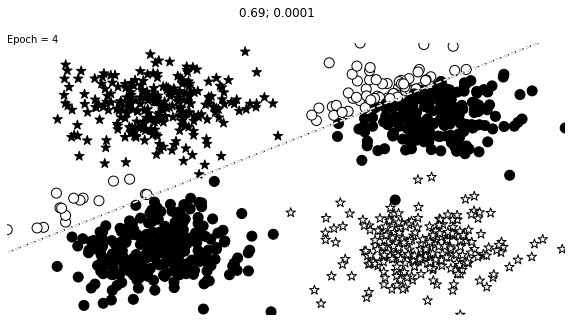

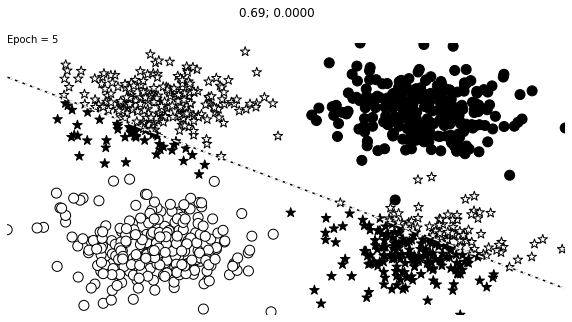

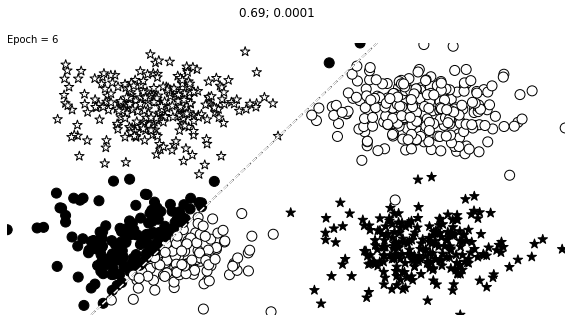

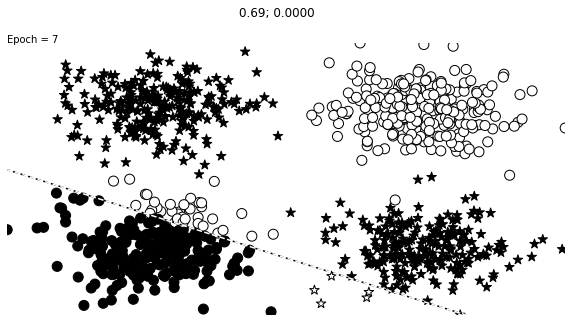

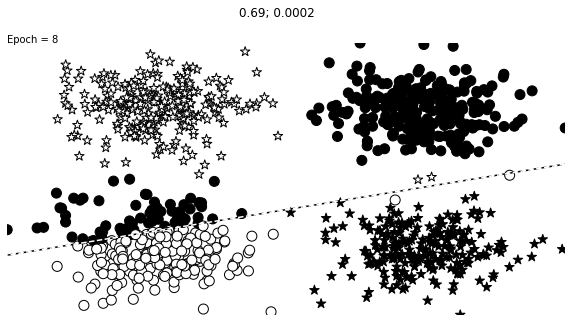

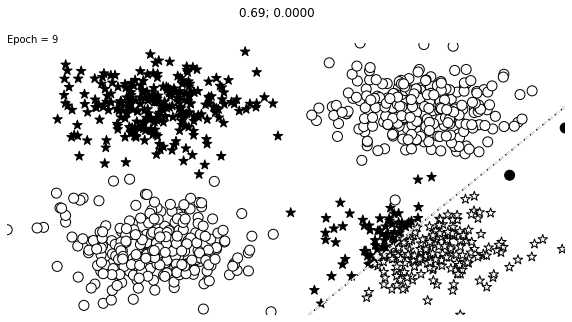

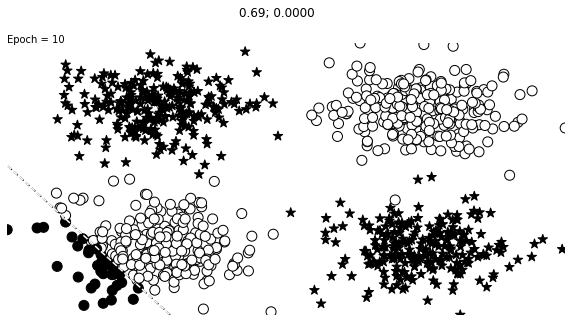

<IPython.core.display.Javascript object>

In [171]:
losses, batch_size, n_batches, max_epochs = [], 10000, 10, 10

loss_change, last_loss, change_threshold, epoch, all_imagefiles = 1.0, 10.0, 1e-3, 0, []

lr = 0.01
optimizer = optim.Adam(params=mlpl.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()


def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs
    return terminate_for_epochs


while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        x_data, y_target = get_toy_data(batch_size)
        mlpl.zero_grad()
        y_pred = mlpl(x_data).squeeze()
        loss = cross_ent_loss(y_pred, y_target.long())
        loss.backward()
        optimizer.step()
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    visualize_results(
        mlpl,
        x_data_static,
        y_truth_static,
        ax=ax,
        epoch=epoch,
        title=f"{loss_value:0.2f}; {loss_change:0.4f}",
    )
    plt.axis("off")
    epoch += 1
    all_imagefiles.append(f"images/perceptron_epoch{epoch}_toylearning_png")
    plt.savefig(all_imagefiles[-1])

#### Training a 2 Layer multilayer perceptron

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


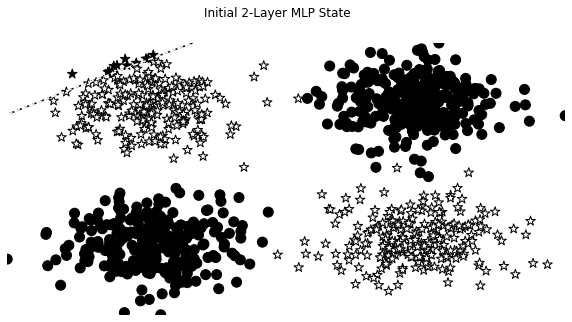

<IPython.core.display.Javascript object>

In [176]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 1
hidden_size = 2

seed = 2

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp2 = MultilayerPerceptron(
    input_size=input_size,
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    output_size=output_size,
)
print(mlp2)

batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_results(
    mlp2,
    x_data_static,
    y_truth_static,
    ax=ax,
    title="Initial 2-Layer MLP State",
    levels=[0.5],
)

plt.axis("off")
plt.savefig("images/mlp2_initial.png")

<ipython-input-167-9ae7b21b8e96>:65: UserWarning: No contour levels were found within the data range.
  ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)


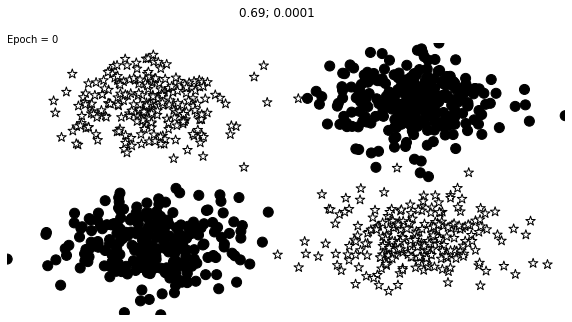

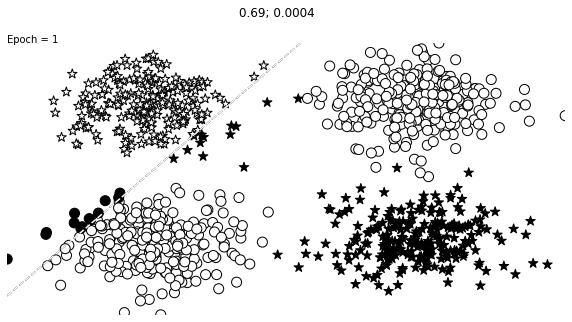

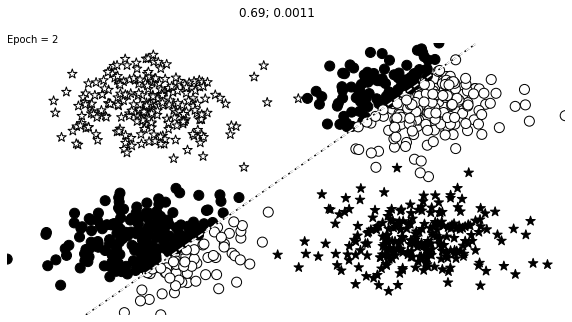

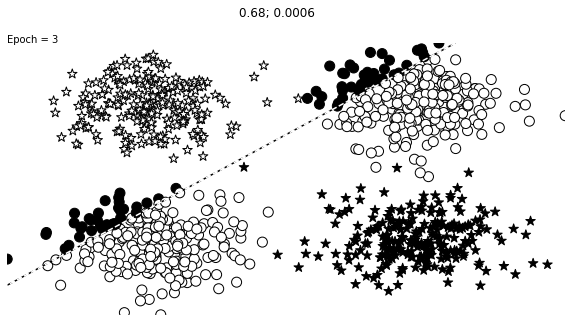

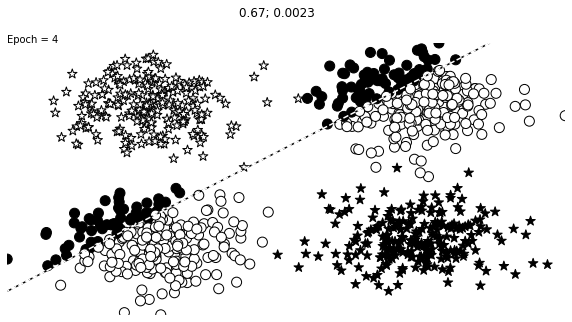

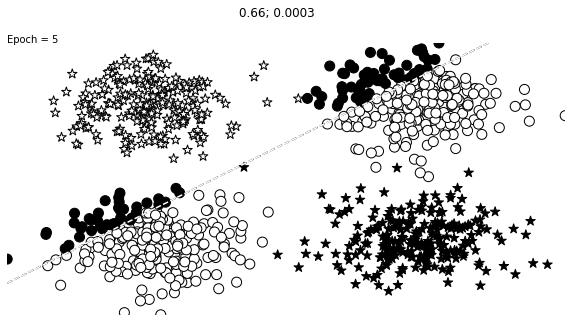

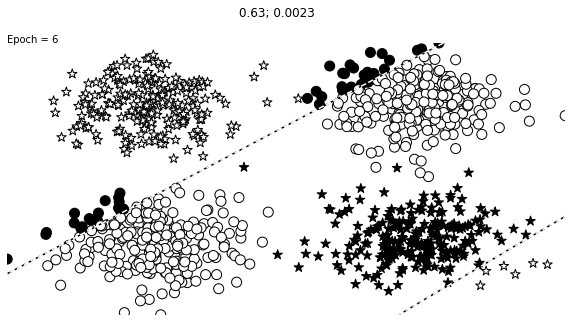

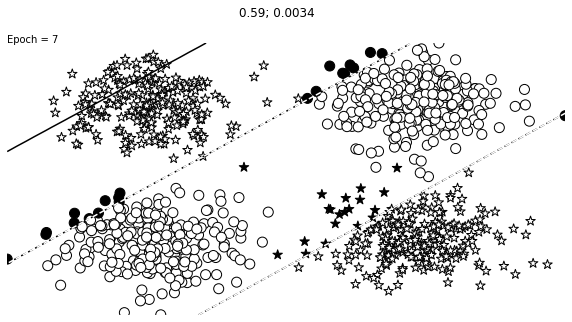

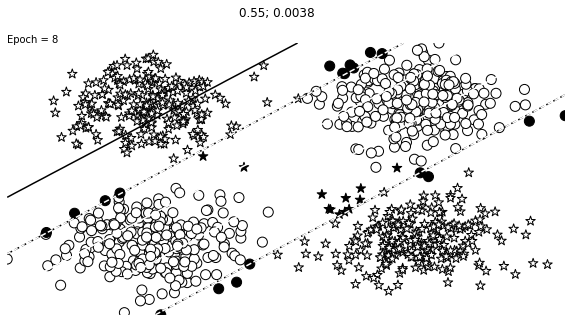

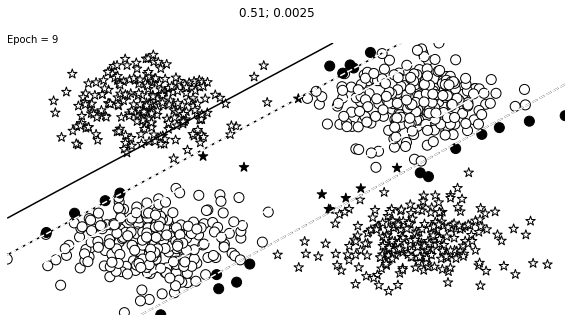

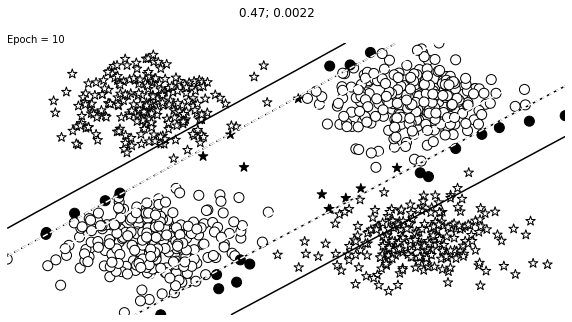

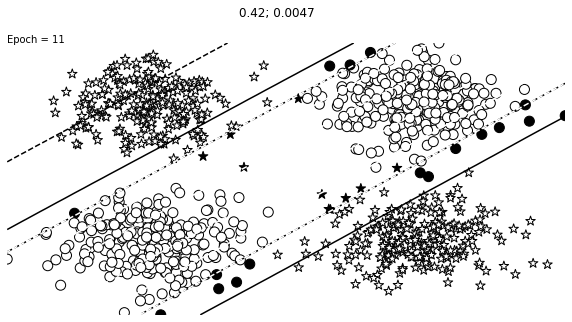

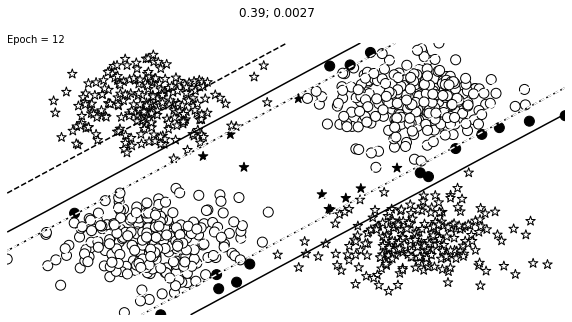

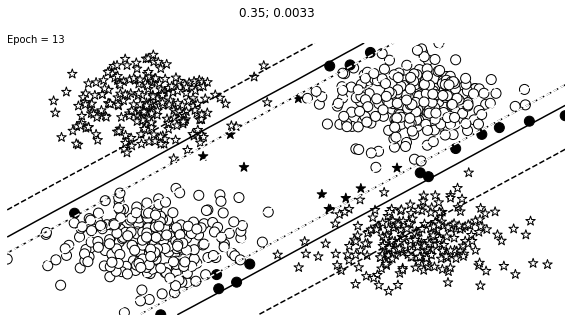

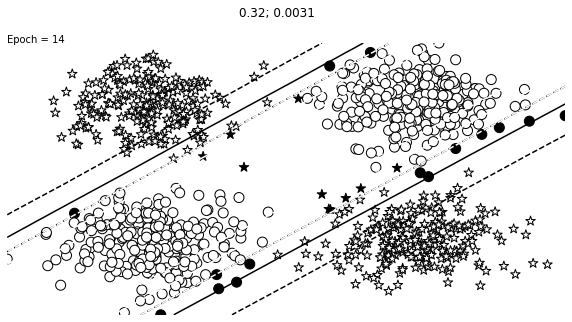

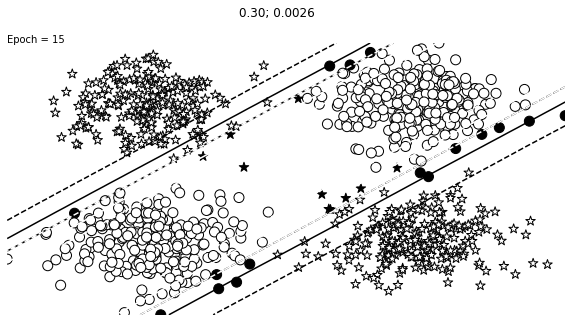

<IPython.core.display.Javascript object>

In [177]:
losses, batch_size, n_batches, max_epochs = [], 10000, 10, 15

loss_change, last_loss, change_threshold, epoch, all_imagefiles = 1.0, 10.0, 1e-5, 0, []

lr = 0.01
optimizer = optim.Adam(params=mlp2.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()


def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs
    return terminate_for_epochs


while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        x_data, y_target = get_toy_data(batch_size)
        mlp2.zero_grad()
        y_pred = mlp2(x_data).squeeze()
        loss = cross_ent_loss(y_pred, y_target.long())
        loss.backward()
        optimizer.step()
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    visualize_results(
        mlp2,
        x_data_static,
        y_truth_static,
        ax=ax,
        epoch=epoch,
        title=f"{loss_value:0.2f}; {loss_change:0.4f}",
    )
    plt.axis("off")
    epoch += 1
    all_imagefiles.append(f"images/mlp2_epoch{epoch}_toylearning_png")
    plt.savefig(all_imagefiles[-1])

#### Training a 3 Layer Multilayer Perceptron

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


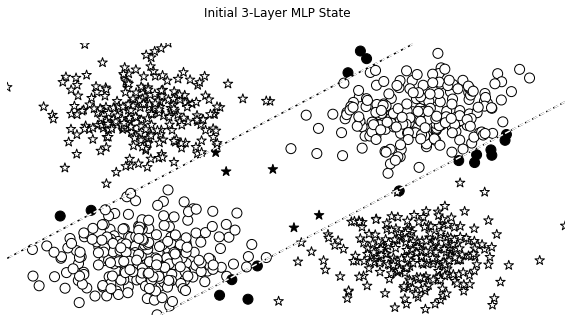

<IPython.core.display.Javascript object>

In [178]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 2
hidden_size = 2

seed = 339

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp3 = MultilayerPerceptron(
    input_size=input_size,
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    output_size=output_size,
)
print(mlp2)

batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_results(
    mlp2,
    x_data_static,
    y_truth_static,
    ax=ax,
    title="Initial 3-Layer MLP State",
    levels=[0.5],
)

plt.axis("off")
plt.savefig("images/mlp3_initial.png")

<ipython-input-167-9ae7b21b8e96>:65: UserWarning: No contour levels were found within the data range.
  ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)


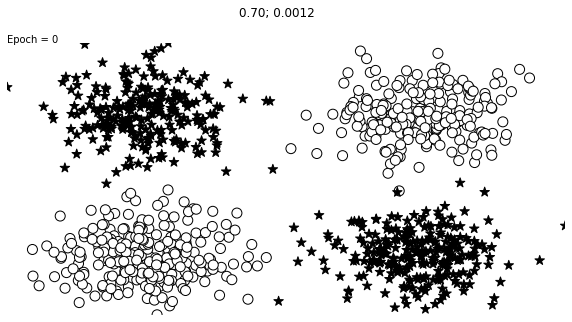

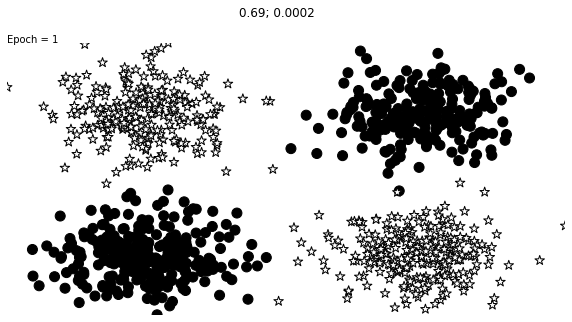

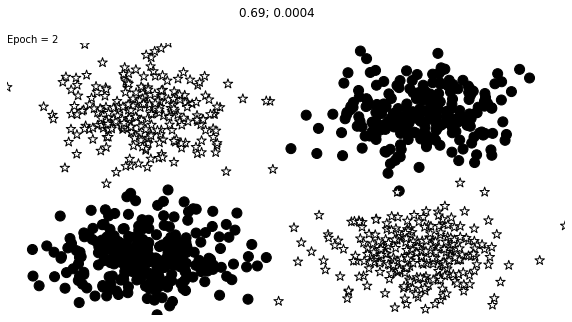

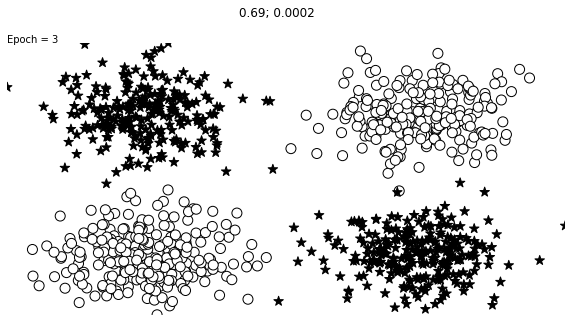

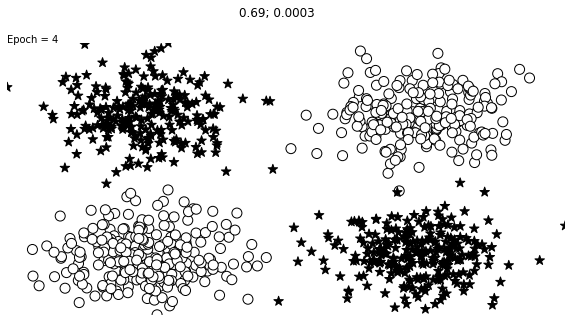

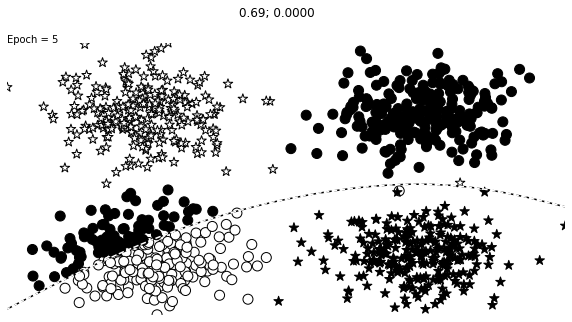

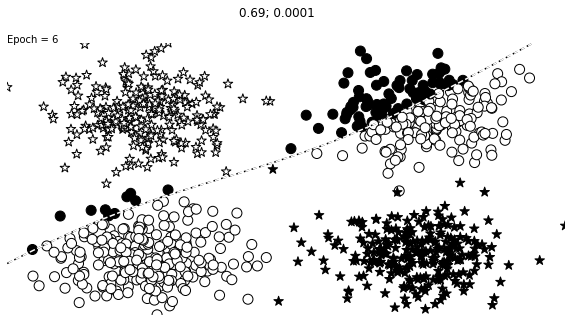

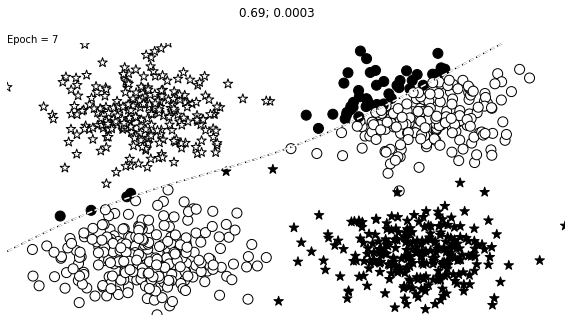

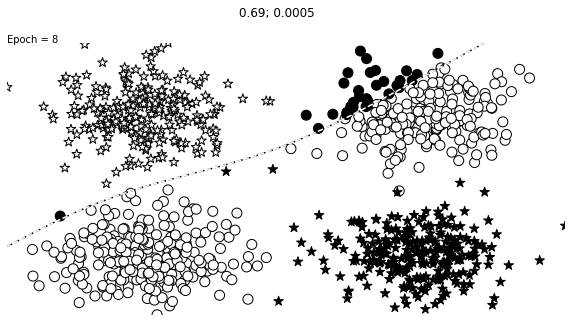

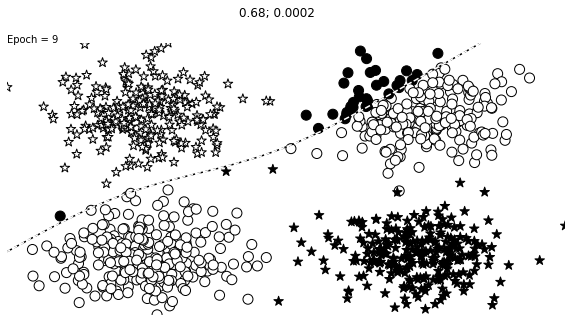

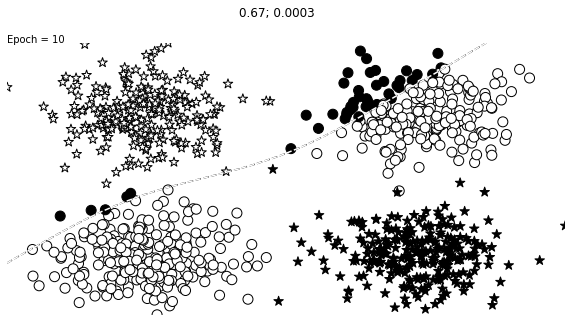

<IPython.core.display.Javascript object>

In [179]:
losses, batch_size, n_batches, max_epochs = [], 10000, 10, 10

loss_change, last_loss, change_threshold, epoch, all_imagefiles = 1.0, 10.0, 1e-5, 0, []

lr = 0.01
optimizer = optim.Adam(params=mlp3.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()


def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs
    return terminate_for_epochs


while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        x_data, y_target = get_toy_data(batch_size)
        mlp3.zero_grad()
        y_pred = mlp3(x_data).squeeze()
        loss = cross_ent_loss(y_pred, y_target.long())
        loss.backward()
        optimizer.step()
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    visualize_results(
        mlp3,
        x_data_static,
        y_truth_static,
        ax=ax,
        epoch=epoch,
        title=f"{loss_value:0.2f}; {loss_change:0.4f}",
    )
    plt.axis("off")
    epoch += 1
    all_imagefiles.append(f"images/mlp3_epoch{epoch}_toylearning_png")
    plt.savefig(all_imagefiles[-1])

#### Comparision

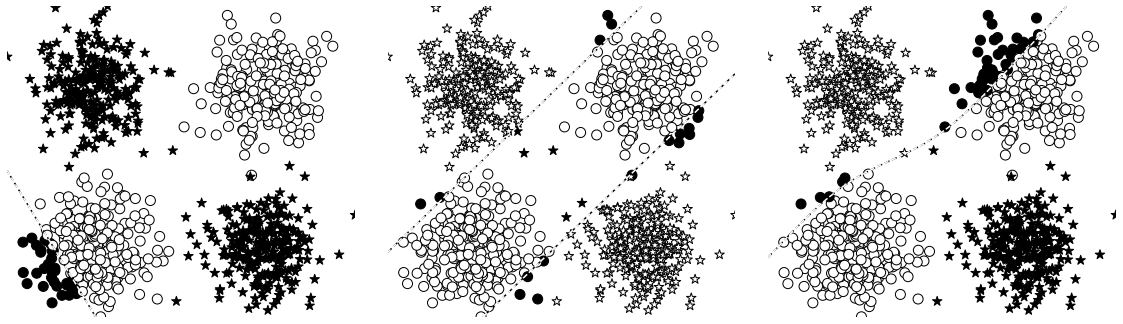

<IPython.core.display.Javascript object>

In [181]:
_, axes = plt.subplots(1, 3, figsize=(16, 5))
visualize_results(
    mlpl, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0]
)
visualize_results(
    mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1]
)
visualize_results(
    mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[2]
)
plt.tight_layout()
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")
plt.savefig("images/perceptron_vs_mlp2_vs_mlp3.png")

#### Inspecting the representations

In [182]:
batch_size = 100


def plot_intermediate_representations(mlp_model, plot_title, figsize=(10, 2)):
    x_data, y_target = get_toy_data(batch_size)

    y_pred = mlp_model(x_data, True).detach().numpy()

    x_data = x_data.numpy()
    y_target = y_target.numpy()

    colors = ["black", "white"]
    markers = ["o", "*"]

    #     plot_colors = []
    #     for i in range(y_target.shape[0]):
    #         plot_colors.append(colors[y_target[i]])

    plot_markers = []
    class_zero_indices = []
    class_one_indices = []
    for i in range(y_target.shape[0]):
        if y_target[i] == 0:
            class_zero_indices.append(i)
        else:
            class_one_indices.append(i)
    class_zero_indices = np.array(class_zero_indices)
    class_one_indices = np.array(class_one_indices)
    # plot_markers.append(markers[y_target[i]])

    fig, axes = plt.subplots(1, len(mlp_model.last_forward_cache), figsize=figsize)

    for class_index, data_indices in enumerate([class_zero_indices, class_one_indices]):

        axes[0].scatter(
            x_data[data_indices, 0],
            x_data[data_indices, 1],
            edgecolor="black",
            facecolor="white",
            marker=markers[class_index],
            s=[200, 400][class_index],
        )
        axes[0].axis("off")
        for i, activations in enumerate(mlp_model.last_forward_cache[1:], 1):
            axes[i].scatter(
                activations[data_indices, 0],
                activations[data_indices, 1],
                edgecolor="black",
                facecolor="white",
                marker=markers[class_index],
                s=[200, 400][class_index],
            )
            axes[i].axis("off")

    plt.tight_layout()

    plt.suptitle(plot_title, size=15)
    plt.subplots_adjust(top=0.75)

<IPython.core.display.Javascript object>

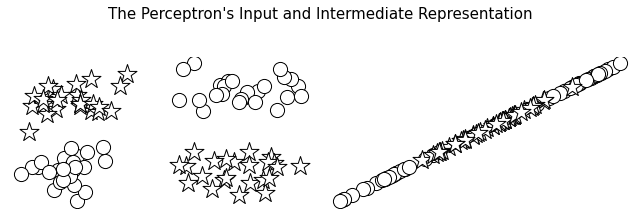

<IPython.core.display.Javascript object>

In [184]:
plot_intermediate_representations(
    mlpl, "The Perceptron's Input and Intermediate Representation", figsize=(9, 3)
)
plt.savefig("images/perceptron_intermediate.png")
plt.savefig("images/figure_4_5.pdf")

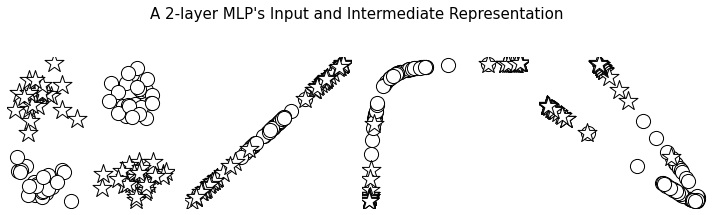

<IPython.core.display.Javascript object>

In [185]:
plot_intermediate_representations(
    mlp2, "A 2-layer MLP's Input and Intermediate Representation", figsize=(10, 3)
)
plt.savefig("images/mlp2_intermediate.png")
plt.savefig("images/figure_4_4.pdf")

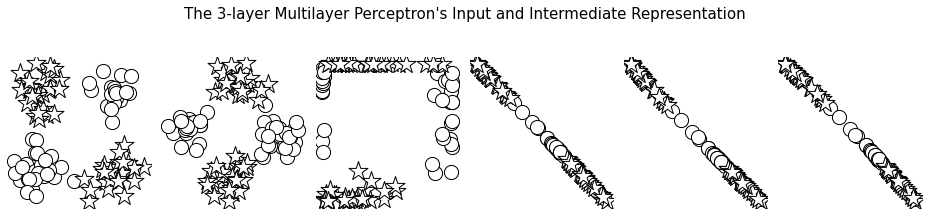

<IPython.core.display.Javascript object>

In [186]:
plot_intermediate_representations(
    mlp3,
    "The 3-layer Multilayer Perceptron's Input and Intermediate Representation",
    figsize=(13, 3),
)
plt.savefig("images/mlp3_intermediate.png")
plt.savefig("images/mlp3_intermediate.pdf")

## Example: Surname classification with MLP

In [ ]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

### The Vocabulary

In [ ]:
class Vocabulary(object):
    """
    Class to process text and extract vocabulary for mapping.
    """

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)

    def to_serializable(self):
        """
        Returns a dictionary that can be serialized.
        """
        return {
            "token_to_idx": self._token_to_idx,
            "add_unk": self._add_unk,
            "unk_token": self._unk_token,
        }

    @classmethod
    def from_serializable(cls, contents):
        """
        Instantiates the Vocabulary from a serialized dictionary.
        """
        return cls(**contents)

    def add_token(self, token):
        """
        Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary.
        Returns:
            index (int): the integer corresponding to the token.
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """
        Add a list of tokens into the Vocabulary

        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens.
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """
        Retrieve the index for given token. Returns UNK index
        if token is not found.

        Args:
            token (str): the token to look up.
        Returns:
            index (int): the index corresponding to the token
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """
        Return the token associated with the index

        Args:
            index (int): the index to lookup
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError(f"the index {index} is not in the Vocabulary")
        return self._idx_to_token[index]

    def __str__(self):
        return f"<Vocabulary(size={len(self)})>"

    def __len__(self):
        return len(self._token_to_idx)

### The Vectorizer

In [ ]:
class SurnameVectorizer(object):
    """
    The Vectorizer which coordinates the Vocabularies and puts them to use.
    """

    def __init__(self, surname_vocab, nationality_vocab):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        """
        Instantiate the vectorizer from the dataset dataframe.

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents["surname_vocab"])
        nationality_vocab = Vocabulary.from_serializable(contents["nationality_vocab"])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab)

    def to_serializable(self):
        return {
            "surname_vocab": self.surname_vocab.to_serializable(),
            "nationality_vocab": self.nationality_vocab.to_serializable(),
        }

### The Dataset

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset.
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset.
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer
        self.train_df = self.surname_df[self.surname_df.split == "train"]
        self.train_size = len(self.train_df)
        self.val_df = self.surname_df[self.surname_df.split == "val"]
        self.validation_size = len(self.val_df)
        self.test_df = self.surname_df[self.surname_df.split == "test"]
        self.test_size = len(self.test_df)

        self._lookup_dict = {
            "train": (self.train_df, self.train_size),
            "val": (self.val_df, self.validation_size),
            "test": (self.test_df, self.test_size),
        }
        self.set_split("train")
        class_counts = surname_df.nationality.value_counts().to_dict()

        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])

        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """
        Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split == "train"]
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_file_path):
        """
        Load dataset and the corresponding vectorizer. Used when vectorizer
        has been cached for re-use.

        Args:
            surname_csv (str)" location of the dataset"
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_file_path)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """
        A static method for loading the vectorizer from file

        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """
        Saves the vectorizer to disk using JSON

        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """
        Returns the vectorizer
        """
        return self._vectorizer

    def set_split(self, split="train"):
        """
        Selects the splits in the datatset using a column in the dataframe.
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """
        The primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data poiint's:
                feature (x_surname)
                label (y_nationality)
        """
        row = self._target_df.iloc[index]
        surname_vector = self._vectorizer.vectorize(row.surname)
        nationality_index = self._vectorizer.nationality_vocab.lookup_token(
            row.nationality
        )
        return {"x_surname": surname_vector, "y_nationality": nationality_index}

    def get_num_batches(self, batch_size):
        """
        Given a batch size, return the number of batches in the dataset.

        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """


def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader.
    It will ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last
    )
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### The Model: SurnameClassifier

In [ ]:
class SurnameClassifier(nn.Module):
    """
    A 2-layer Multilayer Perceptron for classifying surnames.
    """

    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear Layer
            output_dim (int): the output size of the second Linear Layer
        """
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """
        The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                X_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)
        return prediction_vector

### Helper Functions

In [146]:
def make_train_state(args):
    return {
        "stop_early": False,
        "early_stopping_step": 0,
        "early_stopping_best_val": 1e8,
        "learning_rate": args.learning_rate,
        "epoch_index": 0,
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "test_loss": -1,
        "test_acc": -1,
        "model_filename": args.model_state_file,
    }


def update_train_state(args, model, train_state):
    """
    Handle the training state updates.

    Components:
    - Early Stopping to prevent overfitting
    - Saves model if the model is better

    Args:
        args: main arguments
        model: model to train
        train_state: a dict representing the training state values
    Returns:
        a new train_state
    """
    if train_state["epoch_index"] == 0:
        torch.save(model.state_dict(), train_state["model_filename"])
        train_state["stop_early"] = False
    elif train_state["epoch_index"] >= 1:
        loss_tm1, loss_t = train_state["val_loss"][-2:]
        if loss_t >= train_state["early_stopping_best_val"]:
            train_state["early_stopping_step"] += 1
        else:
            if loss_t < train_state["early_stopping_best_val"]:
                torch.save(model.state_dict(), train_state["model_filename"])
            train_state["early_stopping_step"] = 0
        train_state["stop_early"] = (
            train_state["early_stopping_step"] >= args.early_stopping_criteria
        )
    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100


def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)


def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

<IPython.core.display.Javascript object>

### Init

In [147]:
args = Namespace(
    # Data and path information
    surname_csv="../data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="models/chapter04/surname_mlp",
    # Model hyper parameters
    hidden_dim=300,
    # Training  hyper parameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    print(f"Expanded Filepaths: {args.vectorizer_file}, {args.model_state_file}")
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print(f"Using CUDA: {args.cuda}")
set_seed_everywhere(args.seed, args.cuda)
handle_dirs(args.save_dir)

Expanded Filepaths: models/chapter04/surname_mlp/vectorizer.json, models/chapter04/surname_mlp/model.pth
Using CUDA: False


<IPython.core.display.Javascript object>

In [148]:
if args.reload_from_files:
    print("Reloading Dataset")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(
        args.surname_csv, args.vectorizer_file
    )
else:
    print("Creating Fresh Dataset!")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(
    input_dim=len(vectorizer.surname_vocab),
    hidden_dim=args.hidden_dim,
    output_dim=len(vectorizer.nationality_vocab),
)

Creating Fresh Dataset!


<IPython.core.display.Javascript object>

In [149]:
vectorizer.surname_vocab._token_to_idx.keys(), vectorizer.nationality_vocab._token_to_idx.keys()

(dict_keys(['@', 'T', 'o', 't', 'a', 'h', 'A', 'b', 'u', 'd', 'F', 'k', 'r', 'y', 'S', 'e', 'g', 'C', 'm', 'H', 'i', 'K', 'n', 'W', 's', 'f', 'G', 'M', 'l', 'B', 'z', 'N', 'I', 'w', 'D', 'Q', 'j', 'E', 'R', 'Z', 'c', 'Y', 'J', 'L', 'O', '-', 'P', 'X', 'p', ':', 'v', 'U', '1', 'V', 'x', 'q', 'é', 'É', "'", 'ß', 'ö', 'ä', 'ü', 'ú', 'à', 'ò', 'è', 'ó', 'Ś', 'ą', 'ń', 'á', 'ż', 'õ', 'í', 'ñ', 'Á']),
 dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']))

<IPython.core.display.Javascript object>

### Training Loop

In [98]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="min", factor=0.5, patience=1
)

train_state = make_train_state(args)

epoch_bar = tqdm(desc="training routine", total=args.num_epochs, position=0)

dataset.set_split("train")
train_bar = tqdm(
    desc="split=train",
    total=dataset.get_num_batches(args.batch_size),
    position=1,
    leave=True,
)

dataset.set_split("val")
val_bar = tqdm(
    desc="split=val",
    total=dataset.get_num_batches(args.batch_size),
    position=1,
    leave=True,
)

try:
    for epoch_index in range(args.num_epochs):
        train_state["epoch_index"] = epoch_index
        dataset.set_split("train")
        batch_generator = generate_batches(
            dataset, batch_size=args.batch_size, device=args.device
        )
        running_loss, running_acc = 0.0, 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # Step 1. Zero the gradients
            optimizer.zero_grad()

            # Step 2: Compute the output
            y_pred = classifier(batch_dict["x_surname"])

            # Step 3. Compute the loss
            loss = loss_func(y_pred, batch_dict["y_nationality"])
            loss_t = loss.to(args.device).item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # Step 4: Use loss to produce gradients
            loss.backward()

            # Step 5: Use optimizer to take gradient step
            optimizer.step()

            # Compute Accuracy
            acc_t = compute_accuracy(y_pred, batch_dict["y_nationality"])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # Update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state["train_loss"].append(running_loss)
        train_state["train_acc"].append(running_acc)

        # Iterate over val dataset
        dataset.set_split("val")
        batch_generator = generate_batches(
            dataset, batch_size=args.batch_size, device=args.device
        )
        running_loss, running_acc = 0.0, 0.0
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # Compute the output
            y_pred = classifier(batch_dict["x_surname"])

            # Compute the loss
            loss = loss_func(y_pred, batch_dict["y_nationality"])
            loss_t = loss.to(args.device).item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # Compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict["y_nationality"])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state["val_loss"].append(running_loss)
        train_state["val_acc"].append(running_acc)

        train_state = update_train_state(
            args=args, model=classifier, train_state=train_state
        )
        scheduler.step(train_state["val_loss"][-1])

        if train_state["stop_early"]:
            break
        train_bar.n, val_bar.n = 0, 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting Loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train: 0it [00:00, ?it/s]

split=val: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

In [99]:
classifier.load_state_dict(torch.load(train_state["model_filename"]))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split("test")
batch_generator = generate_batches(
    dataset, batch_size=args.batch_size, device=args.device
)

running_loss, running_acc = 0.0, 0.0

classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = classifier(batch_dict["x_surname"])

    # Compute the loss
    loss = loss_func(y_pred, batch_dict["y_nationality"])
    loss_t = loss.to(args.device).item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # Compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict["y_nationality"])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state["test_loss"] = running_loss
train_state["test_acc"] = running_acc

<IPython.core.display.Javascript object>

In [108]:
print(
    f"\nTrain Loss:{train_state['train_loss'][-1]},"
    f" Train Acc:{train_state['train_acc'][-1]}",
    f"\n\nVal Loss:{train_state['val_loss'][-1]},"
    f" Val Acc:{train_state['val_acc'][-1]}",
    f"\n\nTest Loss:{train_state['test_loss']}," f" Test Acc:{train_state['test_acc']}",
)


Train Loss:1.2401203254858655, Train Acc:52.77343750000001 

Val Loss:1.8175728702545166, Val Acc:46.31249999999999 

Test Loss:1.8105636978149413, Test Acc:46.68750000000001


<IPython.core.display.Javascript object>

### Inference

In [113]:
def predict_nationality(surname, classifier, vectorizer):
    """
    Predict the nationality from a new surname

    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifier): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely nationality and its probability
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).view(1, -1)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {"nationality": predicted_nationality, "probability": probability_value}

<IPython.core.display.Javascript object>

In [115]:
new_surname = input("Enter a surname to classify:")
classifier = classifier.to(args.device)
prediction = predict_nationality(new_surname, classifier, vectorizer)
print(f"{new_surname} -> {prediction['nationality']} ({prediction['probability']})")

Enter a surname to classify:McMahan
McMahan -> Irish (0.4362080991268158)


<IPython.core.display.Javascript object>

### Top K Inference

In [116]:
vectorizer.nationality_vocab.lookup_index(8)

'Irish'

<IPython.core.display.Javascript object>

In [117]:
def predict_topk_nationality(name, classifier, vectorizer, k=5):
    vectorized_name = vectorizer.vectorize(name)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    prediction_vector = classifier(vectorized_name, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)

    probability_values = probability_values.detach().numpy()[0]
    indices = indices.detach().numpy()[0]

    results = []

    for prob_value, index in zip(probability_values, indices):
        nationality = vectorizer.nationality_vocab.lookup_index(index)
        results.append({"nationality": nationality, "probability": prob_value})
    return results

<IPython.core.display.Javascript object>

In [120]:
new_surname = input("Enter a surname to classify:")
classifier = classifier.to(args.device)

k = int(input("How many of the top predictions to see? "))

if k > len(vectorizer.nationality_vocab):
    print(
        f"This is more than {len(vectorizer.nationality_vocab)}, defaulting to max size"
    )
    k = len(vectorizer.nationality_vocab)

predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

print(f"Top {k} predictions")
print("=================================")
for prediction in predictions:
    print(f"{new_surname} -> {prediction['nationality']} ({prediction['probability']})")

Enter a surname to classify:Shergill
How many of the top predictions to see? 10
Top 10 predictions
Shergill -> German (0.40713614225387573)
Shergill -> Dutch (0.25716254115104675)
Shergill -> Irish (0.08425957709550858)
Shergill -> Czech (0.07259545475244522)
Shergill -> English (0.05040072649717331)
Shergill -> Scottish (0.025059323757886887)
Shergill -> Arabic (0.023825105279684067)
Shergill -> Russian (0.020161177963018417)
Shergill -> French (0.019863411784172058)
Shergill -> Polish (0.014845119789242744)


<IPython.core.display.Javascript object>

## Convolutional Neural Networks

**MLPs** are not the best tool for taking advantage of sequential patterns in the dataset for ie Surname dataset can have segments that reveal quite a bit about their nation of origin.

**CNNs** are well suited for detecting spatial substrutuce(also creating meaningful spatial substructure as a consequence). CNNs accomplish this by having a small number of weights that use to scan the input data tensors. This scanning produces output tensors that represent the detection of substructures.

_Historical Content_: The name and basic functionality of CNNs stem from a classic mathematical operation called _convolution_. Convolutions have been used in various engineering disciplines, including digital signal processing and computer graphics, for decades now. Classically convolutions have used parameters provided by the programmer. However in deep learning parameters of the convolution filter from data so it is optimal for solving the task at hand

### CNN Hyperparameters

Classic convolutions are designed by specifying the values of the kernel. CNNs are designed by specifying hyperparameters that control the behavior of the CNN and then using gradient descent to find the best parameters for a given dataset.

**Hyperparameters**:

- _Kernel Size_: Control the shape of the consolution.
- _Stride_: Positions the consolution will multiply in the input data tensor.
- _Padding_: Control how much the input data tensor is padded with 0s.
- _Dilation_: Control how far apart the multiplications should be when applied to the input data tensor

![Figure 4.6](../images/figure_4_6.png)

#### Dimension of the convolution Operation

- One Dimensional Convolutions are useful for time series in which each time step has a feature vector. In this situation, we camn learn patterns on the sequence dimension. Most convolution operations in NLP are one dimensional convolutions.
- Two Dimentional Convolution tries to capture spatio temporal patterns along two directions in the data ie in images along the height and width dimensions which is why two dimensional convolutions are popular for image processing.
- Three dimensional convolutions are used to capture patterns in three dimensional data. For ie, video data formation lies in three dimension(two representing the frame of the image and the time dimension representing the sequence of frames)
- PyTorch convolutions can be one-dimensional, two-dimensional, three-dimensional and are implemented by the _Conv1d_, _Conv2d_ and _Conv3d_ modules.

#### Channels

_Channels_ refers to the feature dimension along each point in the input. For example, in images there are three channels for each pixel in the image corresponding to the RGB components. Similarly in text data, convolutions can be applied. If pixels in a text document are words, the number of channels is the size of the vocabulary and if we consider convolution over characters, the number of channels is the size of character set.

In PyTorch convolution implementation, the number of channels in the input is the _in_channels_ argument. The convolution operation can produce more than one channel in the output(_out_channels_). This can be considered as convolution operation mapping the input feature dimension to an output feature dimension.

A common design pattern is not to shrink the number of channels by more than a factor of two from one convolutional layer to the next. This is not an hard-and-fast rule.

![Figure 4.7](../images/figure_4_7.png)
![Figure 4.8](../images/figure_4_8.png)

#### Kernel Size

_Kernel Size_ is the width of the kernel matrix(kernel_size in PyTorch). Intuition to develop here is that convolutions combine spatially local information in the input and the amount of local information per convolution is controlled by the kernel size. Increasing the size of kernel, descreases the size of the output.

Kernel Size behavior in NLP applications is similar to behavior of _n-grams_ which capture patterns in language by looking at groups of words. Small kernel sizes lead to fine grained features in the output, whereas large kernel sizes lead to coarse grained features.

![Figure 4.9](../images/figure_4_9.png)

#### Stride

_Stride_ controls the step size between convolutions. If the stride is the same size as the kernel, the kernel computations do not overlap. On the other hand, if the stride is 1, the kernels are maximally overlapping. The output tensor can be shrunk to summarize information by increasing the stride.

![Figure 4.10](../images/figure_4_10.png)

#### Padding

_stride_ and _kernel_size_ can shrink the total size of feature map as an side effect of controlling the scope of eeach computed feature value. To counter this, the input data tensor is artifically made larger in length. height, depth by appending and prepending 0s to each respective dimension. This mean that CNN will perform more convolutions but the output shape can be controlled without compromising the desired kernel size, stride or dilation.

![Figure 4.11](../images/figure_4_11.png)

#### Dilation

_Dilation_ controls how the convolutional kernel is applied to the input matrix. Increasing the dilation from 1 to 2 means that the elements of the kernel are two spaces away from each other when applied to the input matrix. Another way to think about this is striding in the kernel itself - there is a step size beyween the elements in the kernel or application of kernel with holes.

![Figure 4.12](../images/figure_4_12.png)